<a href="https://colab.research.google.com/github/BDouchet/StackGan_flickr30k/blob/main/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Read Data**

The dataset is composed of >30k images of size 256x256 mostly representing human interaction. The image format is *.jpg*. A csv file compile the associated captions of the images. It is available [here](https://www.kaggle.com/hsankesara/flickr-image-dataset) and was originally composed of various image sizes.

In [ ]:
!nvidia-smi -L

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras import models,optimizers,layers
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.callbacks import TensorBoard
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from os import listdir

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1BzL7oYRJm8wG0yAMamaUP-wZraD7Qjku'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('flickr30k_images.zip')

with ZipFile('flickr30k_images.zip', 'r') as zip:
   zip.extractall()
   print('Done')

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-35aa248c-a760-c6d7-2af9-5ed451eb4f7a)
Done


Store the captions into a pandas file : 
- captions are stored in the result.csv file
- For each picture we have 5 comments which makes a total of 158915 comments.
- The 20,000th rows miss a '|' separator

In [ ]:
df=pd.read_csv('/content/results.csv',sep='|')
df=df.rename(columns={' comment_number':'comment_number',' comment':'comment'})
print(df.columns)
df.loc[19999]['comment_number','comment']=[4,'A dog runs across the grass .']
df['comment_number']=pd.to_numeric(df['comment_number'])
df

Index(['image_name', 'comment_number', 'comment'], dtype='object')


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...
158911,998845445.jpg,1,"A young man hanging over the side of a boat ,..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue an...
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with ..."


To get all the filenames

In [ ]:
filenames=df.image_name.unique()
filenames

array(['1000092795.jpg', '10002456.jpg', '1000268201.jpg', ...,
       '997876722.jpg', '99804383.jpg', '998845445.jpg'], dtype=object)

Multi Index to better acces the comments

In [ ]:
captions=df.set_index(['image_name','comment_number'])
captions

comment
image_name     comment_number                                                   
1000092795.jpg 0                Two young guys with shaggy hair look at their...
               1                Two young , White males are outside near many...
               2                Two men in green shirts are standing in a yard .
               3                    A man in a blue shirt standing in a garden .
               4                         Two friends enjoy time spent together .
...                                                                          ...
998845445.jpg  0                A man in shorts and a Hawaiian shirt leans ov...
               1                A young man hanging over the side of a boat ,...
               2                A man is leaning off of the side of a blue an...
               3                A man riding a small boat in a harbor , with ...
               4                A man on a moored blue and white boat with hi...

[158915 rows x 1 columns]

Read an image and its associated caption.

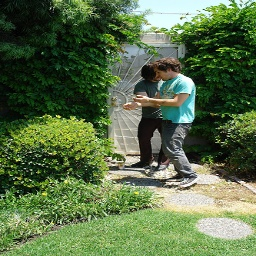

 Two men in green shirts are standing in a yard .


(256, 256, 3)

In [ ]:
def read_image_caption(img,number):
    #read the image
    img_path = 'images/'+img
    im=cv2.imread(img_path)
    comment=captions.loc[img,number]['comment']
    return im, comment

img, text = read_image_caption('1000092795.jpg',2)
cv2_imshow(img)
print(text)
img.shape


# **Process images and captions**

Process the captions from a string to an array of fixed size in order to be understood by a neural network.

## Generate 64x64 images

- The 256x256 images are stored in the directory /images
- The 64x64 images are stored in the directory /images64
- An X matrix of all images is generated

In [ ]:
X=[]
for file in filenames:
    X.append(plt.imread('images64/'+file))
X=np.array(X)
X.shape

(31783, 64, 64, 3)

## Text to sequence

- The aim is to vectorise the captions in order to feed the GAN. 
- We used a pretrained embedding network (glove) with our custom dictionnary.
- All the captions are cleaned to select the most relevant words
- The size is limited (or padded) to 10 relevant words
- The captions are preprocessed to embedded vectors in order to reduce calculation costs

Download English Stopwords and import other libraries

In [ ]:
import nltk  
import random  
import re
nltk.download('stopwords')  
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


We have treated each caption individually in order to remove : 
- punctuation
- numbers (1, 2, 3, ...)
- stopwords: a set of non-characteristic words (is, have, ...)
- single-letter words (a, ...)

In [ ]:
re_punc = re.compile('[%s]' % re.escape(string.punctuation))
stop_words = set(stopwords.words('english'))

def clean_caption(caption):
  tokens = caption.split()  
  tokens = [re_punc.sub('',w) for w in tokens] # enleve les ' et les . 
  tokens = [word for word in tokens if word.isalpha()] # enleve les nombres
  tokens = [word for word in tokens if word not in stop_words] # enleve les stopword
  tokens = [word for word in tokens if len(word) > 1] # on conserve les mots dont la taille est supérieur à 1
  return ' '.join(tokens)

In [ ]:
print(captions['comment'][0])
print(clean_caption(captions['comment'][0]))

 Two young guys with shaggy hair look at their hands while hanging out in the yard .
Two young guys shaggy hair look hands hanging yard


- We have used pre-trained word vectors that can be downloaded from the web. We will use the Glove vector set  with 100 dimensions. [check this](https://colab.research.google.com/drive/1qZScfmCGPhHyZtD8zA4KbRtLMcHUEG1A)
- Embedding_matrix has been generated from the EmbeddingLayer.ipynb file.
- The used words are the 10000 most common words over all the captions (ordered by the most common). 

In [ ]:
embedding_matrix=pd.read_csv('embedding_matrix.csv')
embedding_matrix

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,NaN,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,man,0.37293,0.38503,0.710860,-0.659110,-0.001013,0.92715,0.27615,-0.056203,-0.24294,0.246320,-0.18449,0.313980,0.48983,0.09256,0.329580,0.150560,0.57317,-0.185290,-0.522770,0.461910,0.92038,0.031001,-0.162460,-0.40567,0.786210,0.577220,-0.535010,-0.682280,0.169870,0.363100,-0.071773,0.47233,0.027806,-0.149510,0.175430,-0.375730,-0.785170,0.58171,0.86859,...,0.411510,0.843280,-0.542590,-0.167150,0.739270,-0.093477,0.90278,0.508890,-0.50031,0.264510,0.154430,-0.294320,0.109060,-0.266670,0.354380,0.049079,0.18018,-0.585900,-0.555420,-0.289870,0.742780,0.345300,-0.028757,-0.226460,-1.311300,-0.571900,-0.523060,-0.126700,-0.098678,-0.534630,0.286070,-0.375010,0.45742,0.045975,-0.246750,0.045656,-0.38302,-0.937110,0.039138,-0.539110
2,woman,0.59368,0.44825,0.593200,0.074134,0.111410,1.27930,0.16656,0.240700,0.39045,0.327660,-0.75034,0.350070,0.76057,0.38067,0.175170,0.031791,0.46849,-0.216530,-0.462820,0.399670,0.16623,-0.011477,0.044059,0.30325,0.615300,0.470470,-0.440360,-1.596300,0.184330,0.231930,0.204520,0.51617,0.657340,-0.345200,0.234460,-0.620040,-0.687410,0.28575,1.06050,...,0.440950,0.725880,-0.092053,-0.022406,0.720390,0.107600,0.84116,0.303120,-0.42544,0.056362,0.131090,-0.071181,-0.105790,0.566770,0.545470,0.841130,0.14861,-0.626280,-0.683910,-1.083100,-0.088385,0.321670,0.477940,0.091868,-1.255900,-1.226800,0.085401,0.368330,0.081566,-0.766110,0.877510,-0.220080,0.82401,-0.092207,-0.459410,0.465710,-0.56018,-0.546480,0.151620,-0.307540
3,two,-0.20154,0.32739,0.000476,-0.224520,0.441100,0.33599,0.40657,0.665270,-0.63852,0.044351,0.59747,-0.086113,0.39787,0.88041,0.170050,-0.142750,-0.17920,-0.116220,-0.561750,0.213780,0.95272,-0.276540,0.225670,0.45870,0.832970,-0.904890,-0.240190,-0.416690,-0.318420,0.335990,0.175160,0.24785,-0.360020,-0.118950,0.412390,0.195490,0.071716,0.31329,-0.36803,...,-0.686150,1.149100,0.361290,0.501560,0.339090,0.143700,0.41324,0.751410,0.00799,-0.017592,-0.586090,-0.095992,0.128280,-0.604890,0.272010,0.384970,-0.28595,-0.508070,-1.153900,-0.065888,1.128500,0.284620,-0.247820,0.448590,-1.472600,-0.126820,0.180530,-0.047814,0.016943,-0.225430,-0.227570,0.293410,-0.86753,-0.015261,-1.267500,0.020593,-0.72345,0.023054,0.540160,-0.080331
4,people,0.29019,0.80497,0.311870,-0.327060,-0.472370,1.13630,-0.37966,0.115690,0.41912,0.016284,-0.06543,-0.004047,0.77688,-0.24936,0.188170,-0.640080,-0.02027,-0.185280,-1.065100,0.691150,1.04720,0.361710,0.808630,-0.42767,-0.182990,-0.278470,0.438390,-0.023336,0.373590,-0.358800,0.472610,0.73946,0.015123,0.059862,-0.066841,-0.388420,0.223610,0.80570,0.33789,...,-0.352080,1.489300,-0.217010,-0.246150,0.551850,0.972240,0.58526,-0.029754,0.57944,-0.647980,-0.123710,-0.534590,-0.205280,-0.535990,0.308950,0.539350,0.11853,0.427490,-1.087200,-0.234090,0.738820,0.157490,-0.566420,0.162350,-1.911700,-0.019262,-0.502930,-0.175840,-0.538810,-0.393970,0.813300,-0.316540,0.25971,-0.482020,-1.445200,0.274190,-0.72652,-0.336030,0.459980,-0.112780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Extract the dictionnary from the csv file for the Tokenizer

In [ ]:
words=embedding_matrix['Unnamed: 0'].to_dict()
print(words)
del words[0]
print(words)
dict_words = {v: k for k, v in words.items()}
print(dict_words)

{0: nan, 1: 'man', 2: 'woman', 3: 'two', 4: 'people', 5: 'wearing', 6: 'young', 7: 'white', 8: 'shirt', 9: 'black', 10: 'blue', 11: 'red', 12: 'girl', 13: 'sitting', 14: 'men', 15: 'boy', 16: 'standing', 17: 'dog', 18: 'playing', 19: 'street', 20: 'group', 21: 'front', 22: 'walking', 23: 'holding', 24: 'one', 25: 'water', 26: 'three', 27: 'the', 28: 'women', 29: 'green', 30: 'child', 31: 'looking', 32: 'little', 33: 'an', 34: 'large', 35: 'outside', 36: 'yellow', 37: 'person', 38: 'children', 39: 'brown', 40: 'hat', 41: 'ball', 42: 'small', 43: 'next', 44: 'dressed', 45: 'another', 46: 'running', 47: 'building', 48: 'jacket', 49: 'riding', 50: 'around', 51: 'orange', 52: 'near', 53: 'field', 54: 'crowd', 55: 'stands', 56: 'beach', 57: 'background', 58: 'pink', 59: 'behind', 60: 'sidewalk', 61: 'jumping', 62: 'table', 63: 'girls', 64: 'sits', 65: 'grass', 66: 'snow', 67: 'bike', 68: 'looks', 69: 'top', 70: 'camera', 71: 'air', 72: 'asian', 73: 'dogs', 74: 'stand', 75: 'city', 76: 'wall'

Tokenize the captions into a sequence of indexed numbers (for instance 3 corresponds to the word 'dog').

In [ ]:
maxlen=10
max_words=10000
texts=captions['comment'].to_numpy().copy()
for i,text in enumerate(texts):
    text=clean_caption(text)
    texts[i]=text
tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=max_words,lower='True')
tokenizer.word_index=dict_words
sequences=tokenizer.texts_to_sequences(texts)

We generate the data matrix which gives the position of each word of the caption in the dict_word dictionnary.

In [ ]:
data=tf.keras.preprocessing.sequence.pad_sequences(sequences,maxlen=maxlen,truncating='post')
pd.DataFrame(data,index=texts)

,0,1,2,3,4,5,6,7,8,9
Two young guys shaggy hair look hands hanging yard,0,3,6,270,2018,79,144,121,269,426
Two young White males outside near many bushes,0,0,3,6,7,639,35,52,153,1340
Two men green shirts standing yard,0,0,0,0,3,14,29,203,16,426
man blue shirt standing garden,0,0,0,0,0,1,10,8,16,641
Two friends enjoy time spent together,0,0,0,0,3,421,738,528,9880,102
...,...,...,...,...,...,...,...,...,...,...
man shorts Hawaiian shirt leans rail pilot boat fog mountains background,1,88,2128,8,538,582,2196,137,2719,378
young man hanging side boat like fog rolling hill behind,6,1,269,111,137,289,2719,910,229,59
man leaning side blue white boat sits body water,0,1,308,111,10,7,137,64,245,25
man riding small boat harbor fog mountains background,0,0,1,49,42,137,2228,2719,378,57


Extract the weights for the embedding layer

In [ ]:
weights=embedding_matrix.iloc[:,1:].to_numpy()
weights

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37292999,  0.38503   ,  0.71086001, ..., -0.93711001,
         0.039138  , -0.53911   ],
       [ 0.59368002,  0.44825   ,  0.59320003, ..., -0.54648   ,
         0.15162   , -0.30754   ],
       ...,
       [-1.10790002,  0.20694999,  0.24826001, ...,  0.22685   ,
         0.49617001,  0.25266001],
       [ 0.50827998,  0.46998999,  0.27502   , ..., -0.87492001,
         0.24142   , -0.39998001],
       [ 0.27996001, -0.74748999,  0.21611001, ...,  0.80843002,
         0.33223999, -0.26034999]])

- This step builds our final embedding vector
- We add a layer of Keras Embedding as a first layer. This layer is instantiated by giving the size of the vocabulary, the number of dimensions for the vectors of words to be learned and the size of the input vectors.
- The constructor can take a weight parameter to initialize the matrix of this layer. It is also necessary to indicate that this layer is not trainable by setting the trainable parameter to False


In [ ]:
def Embedding_layer():
    model=models.Sequential()
    model.add(layers.Embedding(10000,100,input_length=10))
    model.add(layers.Flatten())
    model.layers[0].set_weights([weights])
    model.layers[0].trainable=False
    return model
Embedding_vects=Embedding_layer().predict(data)
Embedding_vects.shape

(158915, 1000)

Creation of the dataset to acces the vectors. The dataset is multi indexed according to the name of the image and the comment_number.

In [ ]:
dataset=pd.concat([df,pd.DataFrame(Embedding_vects)],axis=1)
dataset=dataset.drop('comment',axis=1)
dataset['comment_number']=pd.to_numeric(dataset['comment_number'])
dataset=dataset.set_index(['image_name','comment_number'])
dataset

0        1    ...       998       999
image_name     comment_number                    ...                    
1000092795.jpg 0               0.00000  0.00000  ... -0.018952  0.004293
               1               0.00000  0.00000  ...  0.385430  0.019211
               2               0.00000  0.00000  ... -0.018952  0.004293
               3               0.00000  0.00000  ...  0.813160  0.807480
               4               0.00000  0.00000  ...  0.831240  0.387540
...                                ...      ...  ...       ...       ...
998845445.jpg  0               0.37293  0.38503  ...  0.424190 -0.046997
               1               0.27828  0.49947  ...  0.671250 -0.138670
               2               0.00000  0.00000  ...  0.679320  0.349720
               3               0.00000  0.00000  ... -0.152870  0.174420
               4               0.00000  0.00000  ... -0.152870  0.174420

[158915 rows x 1000 columns]

# **Train Vec to Img**

This part is a network trained to take an embedded vector as input and to create an image. It works like the generator in a GAN but without the noise. The advantage is it is more stable for the training but it counter part is it only output the same image for a same input. We voluntarly trained for a long time in order to enhance the prediction quality. 

In [ ]:
model=models.Sequential()
model.add(layers.Dense(512*4*4,input_shape=(1000,),activation='relu',use_bias=False))
model.add(layers.Reshape((4,4,512)))

for filter in [256,128,64,32]:
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(filter,3,strides=1,padding='same',use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))
model.add(layers.Conv2D(3,3,activation='tanh',padding='same'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 8192)              8192000   
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 256)         1179648   
_________________________________________________________________
batch_normalization_22 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 16, 16, 256)      

In [ ]:
file_train=filenames[:28000]
file_test=filenames[28000:]

In [ ]:
batch_size=64

step_ep=int(file_train.shape[0]/batch_size)
step_val=int(file_test.shape[0]/batch_size)


def generate_train():
    while True:
        for index in range(step_ep):
            files=file_train[index * batch_size:(index + 1) * batch_size]
            image_batch=(X[index * batch_size:(index + 1) * batch_size] - 127.5) / 127.5
            embedding_batch = dataset.loc[[(file,random.randint(0,4)) for file in files],range(1000)].to_numpy()
            yield embedding_batch, image_batch

def generate_test():
    while True:
        for index in range(step_val):
            files=file_test[index * batch_size:(index + 1) * batch_size]
            image_batch=(X[index * batch_size:(index + 1) * batch_size] - 127.5) / 127.5
            embedding_batch = dataset.loc[[(file,random.randint(0,4)) for file in files],range(1000)].to_numpy()
            yield embedding_batch, image_batch

model.compile(loss='mse',optimizer='adam',metrics=['acc'])
#history=model.fit(generate_train(),epochs=500,steps_per_epoch=step_ep,validation_data=generate_test(),validation_steps=step_val)

Epoch 1/500
437/437 [==============================] - 7s 15ms/step - loss: 0.2900 - acc: 0.4955 - val_loss: 0.3001 - val_acc: 0.4768
Epoch 2/500
437/437 [==============================] - 6s 15ms/step - loss: 0.2820 - acc: 0.5176 - val_loss: 0.3058 - val_acc: 0.4841
Epoch 3/500
437/437 [==============================] - 6s 15ms/step - loss: 0.2799 - acc: 0.5242 - val_loss: 0.3009 - val_acc: 0.4709
Epoch 4/500
437/437 [==============================] - 6s 15ms/step - loss: 0.2787 - acc: 0.5260 - val_loss: 0.3041 - val_acc: 0.4528
Epoch 5/500
437/437 [==============================] - 6s 15ms/step - loss: 0.2781 - acc: 0.5273 - val_loss: 0.3041 - val_acc: 0.4565
Epoch 6/500
437/437 [==============================] - 6s 15ms/step - loss: 0.2768 - acc: 0.5292 - val_loss: 0.3057 - val_acc: 0.4629
Epoch 7/500
437/437 [==============================] - 6s 15ms/step - loss: 0.2761 - acc: 0.5277 - val_loss: 0.3065 - val_acc: 0.4589
Epoch 8/500
437/437 [==============================] - 6s 15ms

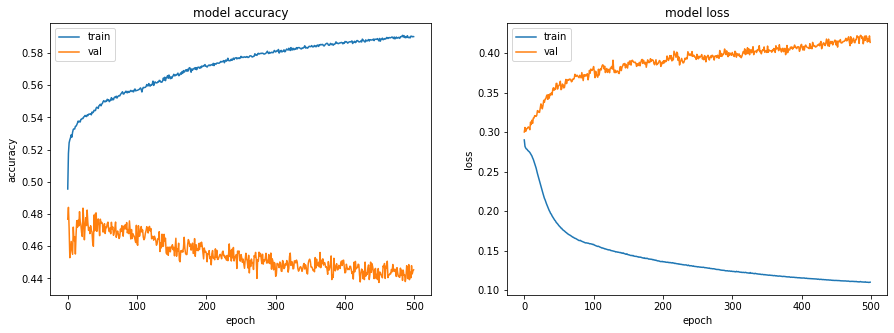

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
model.save('model.h5')

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1IhzvZAoK8wNyaqVl1Go5pMj1kDeImrHZ'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('model.h5')
model=models.load_model('model.h5')

Some prediction samples. Globally the images are really blurred but allows to give an idea of the image.  

In [ ]:
def txt2img(query,display=True):
    query_cleaned=clean_caption(query).lower()
    if display:
        print(query_cleaned)
        for word in query_cleaned.split():
            if word in dict_words:
                print(word + " : understood !")
            else:
                print(word + " : not understood ")
    to_seq=tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([query_cleaned]),
                                                        maxlen=maxlen,truncating='post')
    embed=Embedding_layer().predict(to_seq,verbose=0)
    img_generated=model.predict(embed)

    return img_generated[0]*0.5+0.5

man surfing
man : understood !
surfing : understood !


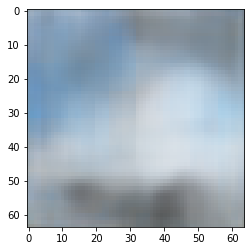

In [ ]:
plt.imshow(txt2img('A man surfing'))

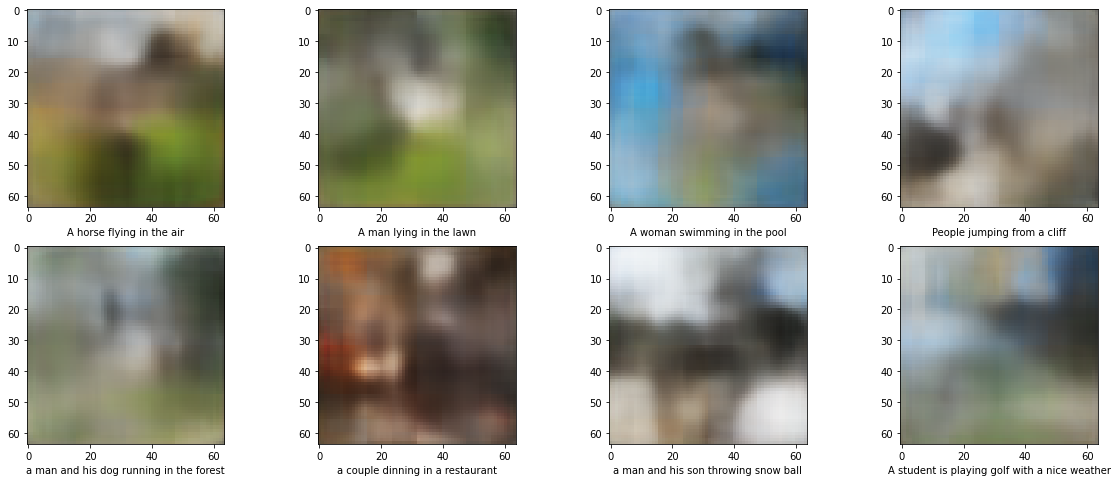

In [ ]:
query='A horse flying in the air'
queries=['A horse flying in the air','A man lying in the lawn','A woman swimming in the pool',
         'People jumping from a cliff','a man and his dog running in the forest','a couple dinning in a restaurant',
         'a man and his son throwing snow ball','A student is playing golf with a nice weather']

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(txt2img(queries[i],False))
    ax.set_xlabel(queries[i])
plt.show()

# **GAN**

An attempt to train a GAN in order to get better and more diverse predictions for the same input.

## Create the models

Generator : 
- The generator goes from an input corresponding to an embedding vector to output a 64x64x3 image.
- It is composed of several layers, including a series of UpSampling + Convolution followed by batch normalisation and a dense neural network with a Leaky ReLU activation function

We tried various size of kernel, number of filters and difference between UpSample2D + Conv2D vs Conv2DTranspose.

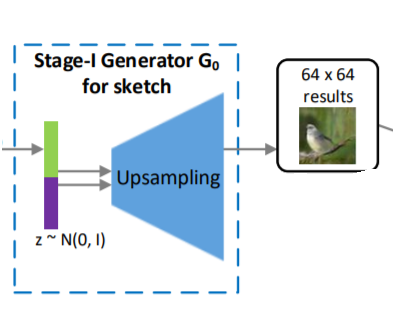




Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 1000)]       0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 128)          128128      input_12[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128)          512         dense_8[0][0]                    
______________________________________________________________________________________

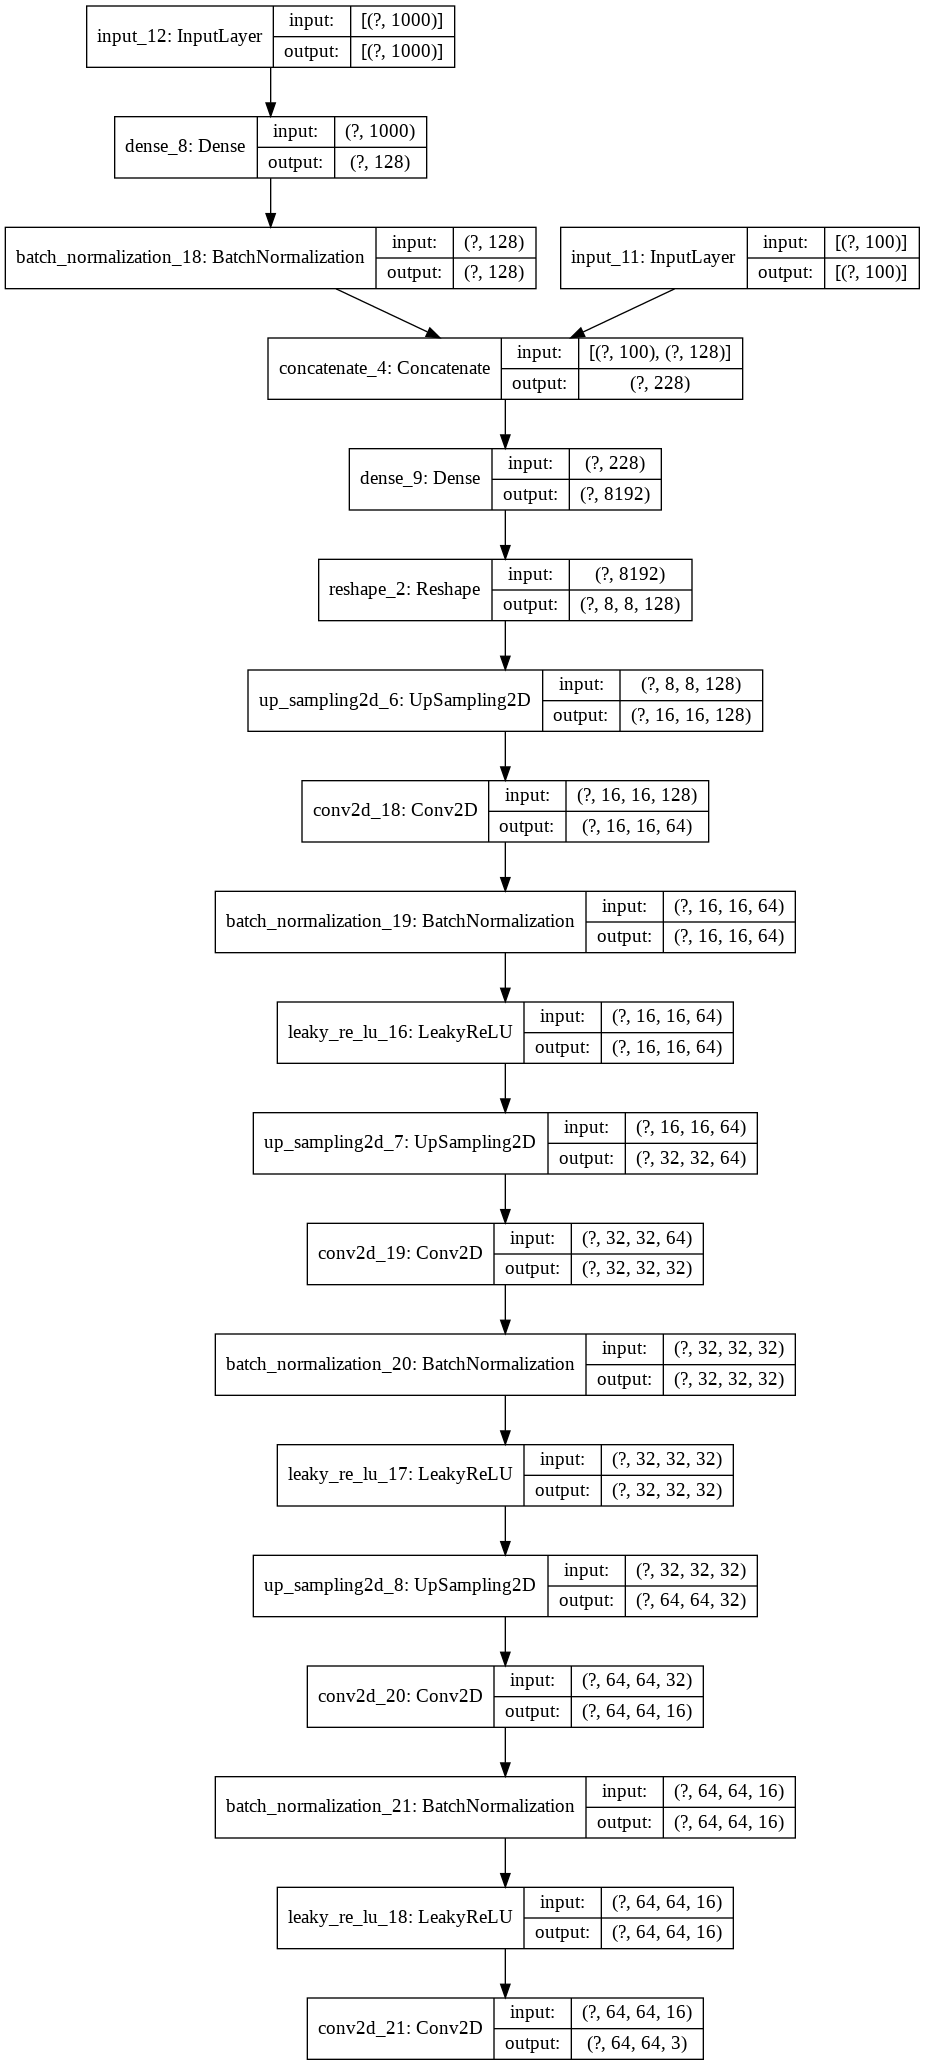

In [ ]:
def generateur():
    z_input=layers.Input(shape=(100,))
    text_input=layers.Input(shape=(1000,))

    x = layers.Dense(128,activation='relu')(text_input)
    x = layers.BatchNormalization()(x)

    x = layers.Concatenate()([z_input,x])
    x = layers.Dense(128*8*8,use_bias=False)(x)
    x = layers.Reshape((8,8,128))(x)

    for filter in [64,32,16]:
        x = layers.UpSampling2D()(x)
        x = layers.Conv2D(filter,3,strides=1,padding='same',use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2D(3,3,activation='tanh',padding='same')(x)
    return models.Model([z_input,text_input],x)

gen=generateur()
print(gen.summary())


plot_model(gen,show_shapes=True)

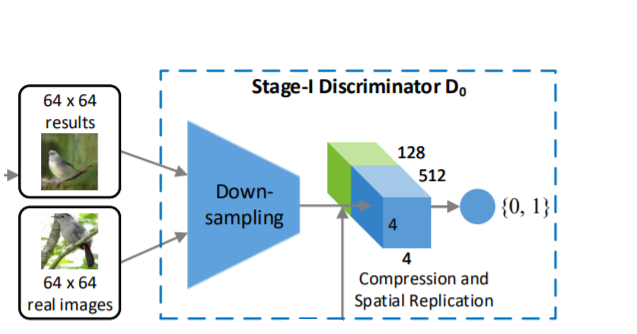


For the discriminator, we used a architecture similarly inversed to the Generator. The idea is to predict between two classes (0 or 1) : fake or real images. At the end of the dicriminator we concatenate a compression of the embedded vector into the discriminator. This allows to transfer caption data into the generator AND the discriminator.

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 64)   3072        input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 32, 32, 64)   256         conv2d_13[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 32, 32, 64)   0           batch_normalization_13[0][0]     
_______________________________________________________________________________________

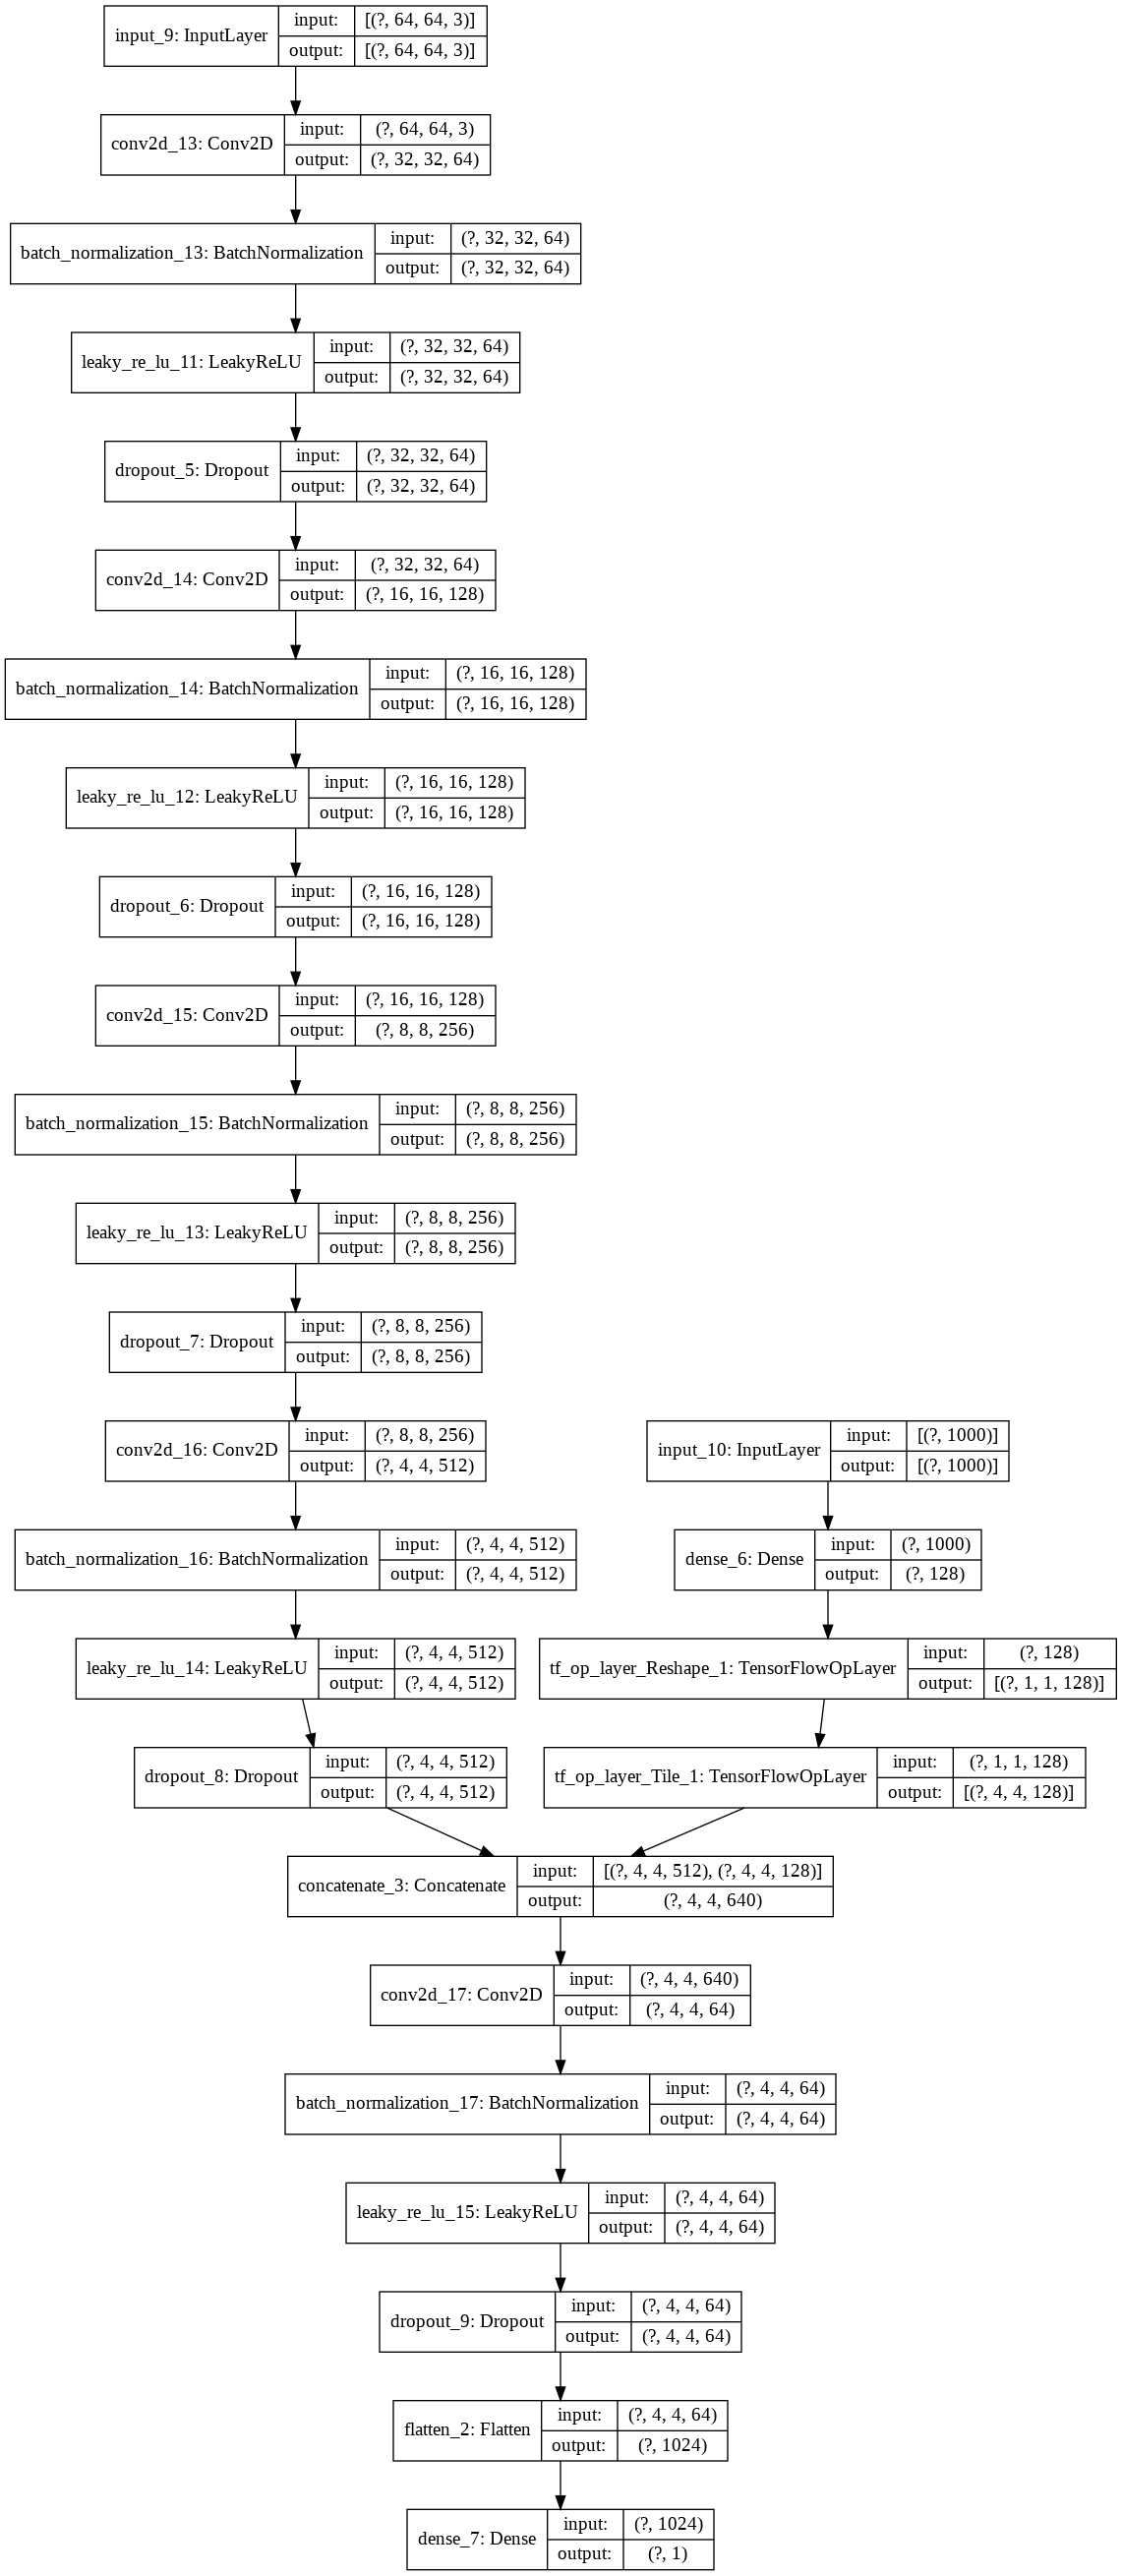

In [ ]:
def discriminator():
    dis_input=layers.Input(shape=(64,64,3))

    x=layers.Conv2D(64,4,strides=2,use_bias=False,padding='same')(dis_input)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.2)(x)

    for filter in [128,256,512]:
        x=layers.Conv2D(filter,4,strides=2,use_bias=False,padding='same')(x)
        x=layers.BatchNormalization()(x)
        x=layers.LeakyReLU(0.2)(x)
        x=layers.Dropout(0.2)(x)

    
    text_input=layers.Input(shape=(1000,))
    compressed = layers.Dense(128,activation='relu')(text_input)
    compressed = tf.reshape(compressed, shape=[-1, 1, 1, 128])
    compressed = tf.tile(compressed, multiples=[1, 4, 4, 1])

    x = layers.Concatenate()([x, compressed])

    x = layers.Conv2D(64, kernel_size=1, padding="same", strides=1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Dropout(0.4)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1,activation='sigmoid')(x)

    return models.Model([dis_input,text_input],x)
discr=discriminator()
print(discr.summary())

plot_model(discr,show_shapes=True)

Build of the adversarial network

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 1000)]       0                                            
__________________________________________________________________________________________________
functional_11 (Functional)      (None, 64, 64, 3)    2094067     input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
functional_9 (Functional)       (None, 1)            2929857     functional_11[0][0]  

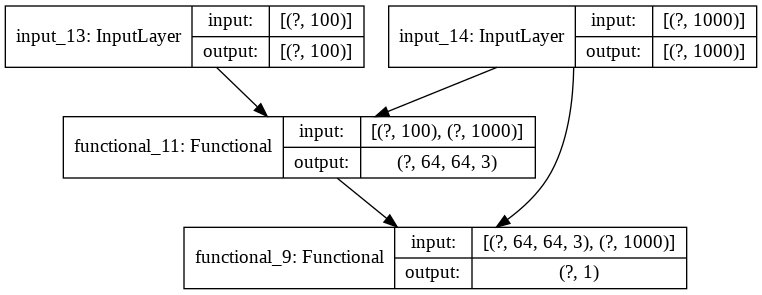

In [ ]:
def adversarial(generator,discriminator):
    discriminator.trainable=False

    gan_input=layers.Input(shape=(100,))
    text_input=layers.Input(shape=(1000,))

    gan_output=discriminator([generator([gan_input,text_input]),text_input])


    gan=models.Model([gan_input,text_input],gan_output)
    return gan
gan=adversarial(gen,discr)
print(gan.summary())

plot_model(gan,show_shapes=True)

## Train 1st Stage GAN

Compiling the models and setting the hyperparameters

In [ ]:
import time

batch_size = 64
z_dim = 100
epochs = 1000

# Define optimizers
dis_optimizer = optimizers.Adam(lr=0.0002, beta_1=0.5)
gan_optimizer = optimizers.Adam(lr=0.0002, beta_1=0.5)

discr.compile(optimizer=dis_optimizer,loss='binary_crossentropy')

gan.compile(optimizer=gan_optimizer,loss='binary_crossentropy')


In [ ]:
filenames_train=filenames[:20000]
filenames_test=filenames[20000:]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def noise(image_batch):
    batch,h, w, c=image_batch.shape
    n=np.random.randn(batch,h, w, c)*random.randint(1, 10)
    return np.clip(image_batch+n, 0, 255).astype(np.uint8)

Epoch is: 0
Number of batches 312
d_loss_real:0.7472356557846069
d_loss_fake:1.0210901498794556
d_loss:0.8841629028320312
g_loss:0.545973002910614
26.46850347518921
Epoch is: 1
Number of batches 312
d_loss_real:0.7383406162261963
d_loss_fake:1.2133885622024536
d_loss:0.975864589214325
g_loss:0.5118732452392578
23.14727473258972
Epoch is: 2
Number of batches 312
d_loss_real:0.7464210987091064
d_loss_fake:1.2995388507843018
d_loss:1.022979974746704
g_loss:0.5055713057518005
23.2372407913208
Epoch is: 3
Number of batches 312
d_loss_real:0.7555384635925293
d_loss_fake:1.3282709121704102
d_loss:1.0419046878814697
g_loss:0.5057940483093262
23.031038999557495
Epoch is: 4
Number of batches 312
d_loss_real:0.7354259490966797
d_loss_fake:1.3015449047088623
d_loss:1.018485426902771
g_loss:0.5063873529434204
22.905459880828857
Epoch is: 5
Number of batches 312
d_loss_real:0.7447737455368042
d_loss_fake:1.327531337738037
d_loss:1.0361525416374207
g_loss:0.5087968111038208
23.219337940216064
Epoch i

KeyboardInterrupt: ignored

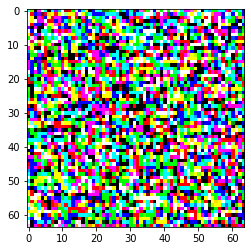

In [ ]:
# label smoothing make the model less overconfident
real_labels = np.ones((batch_size, 1), dtype=float) * 0.8
fake_labels = np.zeros((batch_size, 1), dtype=float) + 0.2

for epoch in range(epochs):
    start=time.time()
    print("========================================")
    print("Epoch is:", epoch)
    print("Number of batches", int(len(filenames_train) / batch_size))

    # Load data and train model
    number_of_batches = int(len(filenames_train)/batch_size)

    for index in range(number_of_batches):
        """
        Train the discriminator network
        """

        # Sample a batch of data
        z_noise = np.random.normal(size=(batch_size, z_dim))
        files=filenames_train[index * batch_size:(index + 1) * batch_size]
        image_batch=(X[index * batch_size:(index + 1) * batch_size] - 127.5) / 127.5
        embedding_batch = dataset.loc[[(file,random.randint(0,4)) for file in files],range(1000)].to_numpy()

        # Generate fake images
        fake_images = gen.predict([z_noise, embedding_batch], verbose=0)

        dis_loss_real = discr.train_on_batch([image_batch, embedding_batch], real_labels)
        dis_loss_fake = discr.train_on_batch([fake_images, embedding_batch], fake_labels)
        d_loss = 0.5 * np.add(dis_loss_real,dis_loss_fake)

        g_loss = gan.train_on_batch([z_noise, embedding_batch], real_labels)        

    print("d_loss_real:{}".format(dis_loss_real))
    print("d_loss_fake:{}".format(dis_loss_fake))
    print("d_loss:{}".format(d_loss))
    print("g_loss:{}".format(g_loss))

    # Generate and save images after every 2nd epoch    
    if epoch % 10 ==0 :
        z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
        files=filenames_test[0:batch_size]
        embedding_batch = dataset.loc[[(file,random.randint(0,4)) for file in files],range(1000)].to_numpy()
        fake_images = gen.predict_on_batch([z_noise2,embedding_batch])

        # Save images
        for i, img in enumerate(fake_images[:5]):
            plt.imshow(img*0.5+0.5)
            plt.savefig("/content/drive/MyDrive/Colab Notebooks/BMDATA/Projet/resultsII/gen_{}_{}.png".format(epoch, i))

        # Save models
        gen.save("/content/drive/MyDrive/Colab Notebooks/BMDATA/Projet/weightsII/gen_{}.h5".format(epoch))
        discr.save("/content/drive/MyDrive/Colab Notebooks/BMDATA/Projet/weightsII/dis_{}.h5".format(epoch))
    print(time.time()-start)


# **Conclusion**



The idea of this project was to create an image thanks to a caption. We encoded the caption through Glove pretrained embedding. 

Our original idea was to use a [StackGan](https://arxiv.org/pdf/1612.03242.pdf) for this problem because it allows to produce high quality images. However, because of the delay, we were not able to train two different GAN.

We focused on the first stage GAN which is really similar to this [one](https://arxiv.org/pdf/1605.05396.pdf). It produces 64x64x3 images thanks to a caption and have been tested on [MS COCO](https://cocodataset.org/#home), which is a dataset similar to our. However the training of a GAN is a really hard process because the equilibrium point is not easy to determine. All our training have been ended with [convergence failure and/or mode collapse](https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/). We tried to strongly imbalance the discriminator or the generator, change their achitecture, the hyperparameters without success.

As a result, we tried to create a simple generator (without noise) that predict one output for an input and it shows intresting results.

To go further, it would be interesting to use our pretrained txt to img for the generator to give a helping hand to the generator. 
